# Twitter datasets analysis

## Imports and configs

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging
import matplotlib.pyplot as plt
import seaborn as sns

import helper
from config import Config
from stages import PreProcessing, CommunityDetection, Metrics, Analysis, Comparisons

logging.basicConfig(filename='logs/debug.log', filemode='w', level=logging.DEBUG,
                    format='%(levelname)s - %(name)s - %(message)s')

DEMON parameters:
* *epsilon*: the tolerance required in order to merge communities
* *min_community_size*: minimum number of nodes needed to form a community

In [2]:
data_filenames = ['ll', 'kdd']
epsilon = [0.25, 0.5, 0.75]
min_community_size = 3

configs = {}
for data_fn in data_filenames:
    configs[data_fn] = []
    for e in epsilon:
        config = Config(
            data_filename=data_fn,
            demon={
                'epsilon': e,
                'min_community_size': min_community_size
            })
        configs[data_fn].append(config)

## Stages

### 1. Pre Processing

In [3]:
for data_fn, config in configs.items():
    pp = PreProcessing(config[0]) # only once per dataset, same for all the cd parameters
    pp.execute()
    pp.save()

### 2. Community Detection

In [4]:
for data_fn, config in configs.items():
    for c in config:
        cd = CommunityDetection(c)
        cd.execute()
        cd.save()

Exec: 100%|████████████████████████

Time:  'execute' 143.90 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 137.92 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 135.92 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.16 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.16 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.18 sec
------------------------------------


### 3. Metrics

In [5]:
m = {}
for data_fn, config in configs.items():
    m[data_fn] = {}
    for c in config:
        m[data_fn][c.demon['epsilon']] = Metrics(c)
        m[data_fn][c.demon['epsilon']].execute()
        m[data_fn][c.demon['epsilon']].save()

100%|██████████| 17/17 [00:00<00:00, 1358.96it/s]


## Analysis

In [6]:
e_pairwise_combs = helper.pairwise_combinations(sorted(epsilon, reverse=True))
e_pairs = [(e,e) for e in epsilon]
metric_name = 'indegree'

### Communities
Found communities per epsilon parameter.

In [7]:
for data_fn in data_filenames:
    print(f'Communities found in {data_fn}')
    display(Analysis.number_of_communities(m[data_fn]))    

Communities found in ll


,epsilon,no. of communities
0,0.25,12
1,0.50,23
2,0.75,45


Communities found in kdd


,epsilon,no. of communities
0,0.25,10
1,0.50,14
2,0.75,17


### Communities quality parameters
Survey of modularity measures: https://github.com/Lab41/survey-community-detection 
* *Internal density*: number of edges (ms) in subset S divided by the total number of possible edges between all nodes (ns(ns-1)/2). Higher the better
* *Average degree*: average internal degree across all nodes (ns) in subset S. Higher the better.
* *FOMD (Fraction over median degree)*: Determines the number of nodes that have an internal degree greater than the median degree of nodes in Subset S. Higher the better.
* *Expansion*: can be thought as “External Degree”. Measure of separability. Lower the better.
* *Cut Ratio*: This metric is a measure of separability and can be thought of as "External Density". Lower the better.
* *Conductance*: Ratio of edges inside the cluster to the number of edges leaving the cluster (captures surface area to volume). Lower the better.
* *Normalized Cut*: Represents how well subset S is separated from graph G. Combines Conductance with the fraction of external edges over all non-community edges. Higher the better.
* *Maximum ODF (Out Degree Fraction)*: Fraction of external conections to internal connections for each node (ns) in S. It then returns the fraction with the highest value. Lower the better.
* *Average ODF*: same as Maximum ODF but takes the average. Lower the better.
* *Flake-ODF*: Fraction of the number of nodes that have fewer internal connections than external connections to the number of nodes (ns) in subset S. Higher the better.


In [8]:
for data_fn in data_filenames:
    print(f'Communities quality parameters found in {data_fn}')
    for e, pq in Analysis.pquality(m[data_fn]):
        print(f'pquality for e={e}')
        display(pq)

Communities quality parameters found in ll
pquality for e=0.25


,min,max,avg,std
Index,,,,
Internal Density,0.001757,0.458333,0.179868,0.169144
Edges inside,11.000000,99913.000000,33990.333333,41909.614771
Average Degree,5.500000,60.564598,24.496000,20.792741
FOMD,0.200000,0.500000,0.417438,0.102055
Expansion,0.000000,26.200000,4.833650,7.583815
Cut Ratio,0.000000,0.004372,0.001125,0.001376
Conductance,0.000000,0.803681,0.146894,0.213120
Normalized Cut,0.000000,0.804302,0.228360,0.208840
Maximum-ODF,0.000000,5880.000000,1335.833333,2109.952047


pquality for e=0.5


,min,max,avg,std
Index,,,,
Internal Density,0.002692,0.458333,0.151390,0.166612
Edges inside,10.000000,90359.000000,25620.391304,33232.484541
Average Degree,5.000000,68.525654,30.301717,23.279401
FOMD,0.166667,0.500000,0.426149,0.101535
Expansion,0.000000,212.042553,38.796474,55.393781
Cut Ratio,0.000000,0.035637,0.006962,0.009256
Conductance,0.000000,0.959596,0.368000,0.337850
Normalized Cut,0.000000,0.995632,0.465795,0.327971
Maximum-ODF,0.000000,8602.000000,3613.391304,3254.972353


pquality for e=0.75


,min,max,avg,std
Index,,,,
Internal Density,0.002388,0.458333,0.124567,0.148277
Edges inside,10.000000,95055.000000,10475.422222,18853.787417
Average Degree,5.000000,74.003749,26.749526,20.108550
FOMD,0.064103,0.500000,0.414937,0.108526
Expansion,0.000000,641.000000,81.226719,101.135728
Cut Ratio,0.000000,0.107012,0.014070,0.016829
Conductance,0.000000,0.988980,0.598064,0.307406
Normalized Cut,0.000000,1.009813,0.682289,0.300696
Maximum-ODF,0.000000,8670.000000,5322.888889,3463.895727


Communities quality parameters found in kdd
pquality for e=0.25


,min,max,avg,std
Index,,,,
Internal Density,0.075287,0.458333,0.288899,0.136870
Edges inside,11.000000,131.000000,45.000000,37.403208
Average Degree,5.500000,9.400000,7.529200,1.238497
FOMD,0.200000,0.500000,0.388233,0.096987
Expansion,0.000000,1.300000,0.486435,0.516081
Cut Ratio,0.000000,0.017808,0.005730,0.006298
Conductance,0.000000,0.155556,0.054334,0.058308
Normalized Cut,0.000000,0.186669,0.065587,0.071238
Maximum-ODF,0.000000,30.000000,6.800000,9.042124


pquality for e=0.5


,min,max,avg,std
Index,,,,
Internal Density,0.094156,0.458333,0.311907,0.108488
Edges inside,11.000000,87.000000,35.357143,23.023613
Average Degree,5.500000,9.750000,7.668699,1.314931
FOMD,0.166667,0.500000,0.386414,0.112680
Expansion,0.000000,3.166667,0.952717,0.966180
Cut Ratio,0.000000,0.032646,0.010143,0.010048
Conductance,0.000000,0.345455,0.099519,0.100123
Normalized Cut,0.000000,0.366827,0.109700,0.107384
Maximum-ODF,0.000000,22.000000,8.571429,7.835034


pquality for e=0.75


,min,max,avg,std
Index,,,,
Internal Density,0.103947,0.458333,0.325536,0.091386
Edges inside,11.000000,79.000000,30.352941,17.398246
Average Degree,5.500000,9.750000,7.528291,1.216483
FOMD,0.166667,0.500000,0.376366,0.110360
Expansion,0.000000,6.800000,1.724930,1.874208
Cut Ratio,0.000000,0.069388,0.017996,0.019220
Conductance,0.000000,0.531250,0.159050,0.153657
Normalized Cut,0.000000,0.568613,0.173154,0.165085
Maximum-ODF,0.000000,34.000000,12.235294,10.712991


### Similarities
Detect similarities between communities of the same partition.
1. get the top 10 nodes in each community wrt the given metric ("indegree" in this case)
2. apply Kendall-Tau given a pair of top 10 ranked communities

Metrics:
* *Kendall Tau*: it takes values between ±1, with a positive correlation indicating that the ranks of
both variables increase together whilst a negative correlation indicates that as the rank of one variable increases the other one decreases.

  source: [2001 Blackwell Science Ltd, Journal of Clinical Nursing](http://www.blackwellpublishing.com/specialarticles/jcn_10_715.pdf)

\begin{align}
\tau = \frac{(\text{# of concordant pairs}) - (\text{# of disconcordant pairs})}
{N \cdot (N-1)/2}
\end{align}

 * *Indegree*: number of edges entering a node in a direct graph.

* *H-Index*: According to the definition of h-index on Wikipedia:
"A scientist has index h if h of his/her N papers have at least h citations each, and the other N − h papers have no more than h citations each."
For example, given citations = [3, 0, 6, 1, 5], which means the researcher has 5 papers in total and each of them had received 3, 0, 6, 1, 5 citations respectively.
Since the researcher has 3 papers with at least 3 citations each and the remaining two with no more than 3 citations each, his h-index is 3.

  Note: If there are several possible values for h, the maximum one is taken as the h-index.

  source: [Leetcode's Github](https://github.com/kamyu104/LeetCode/blob/master/Python/h-index.py)

#### Similarities between SAME epsilon settings
Find similarities between communities of the same partition settings (since we are using overlapping commmunities detection).

heatmaps for dataset ll


/home/flaprimo/Development/Workspaces/ZikaProject/Python/twitter-network-analysis/venv/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


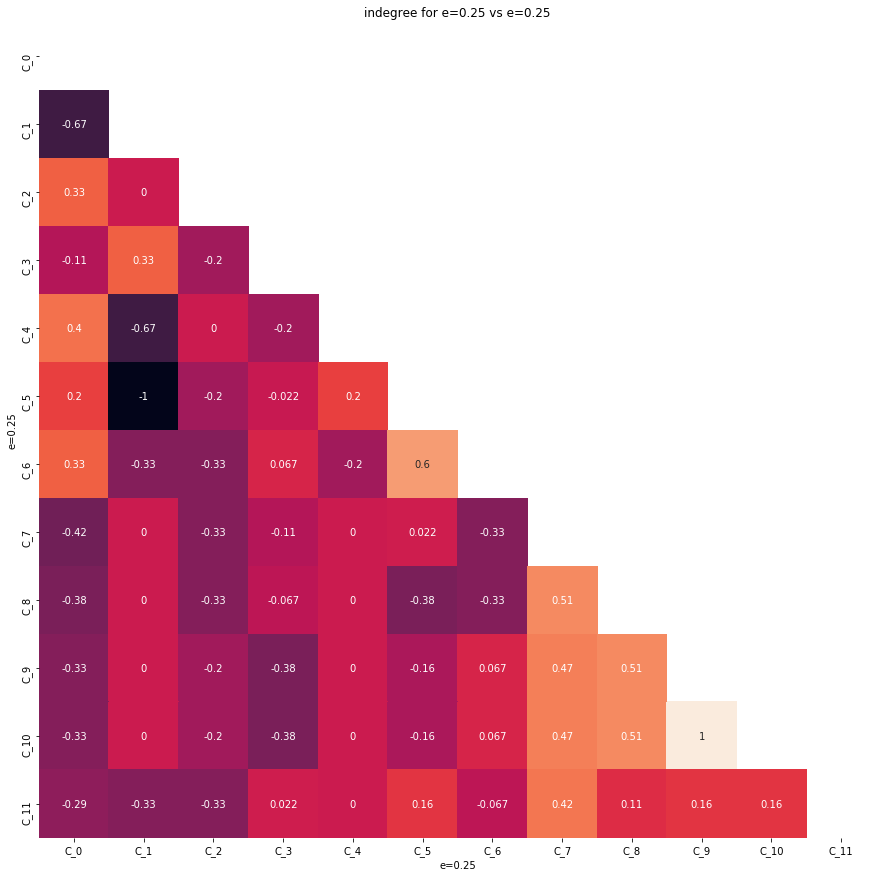

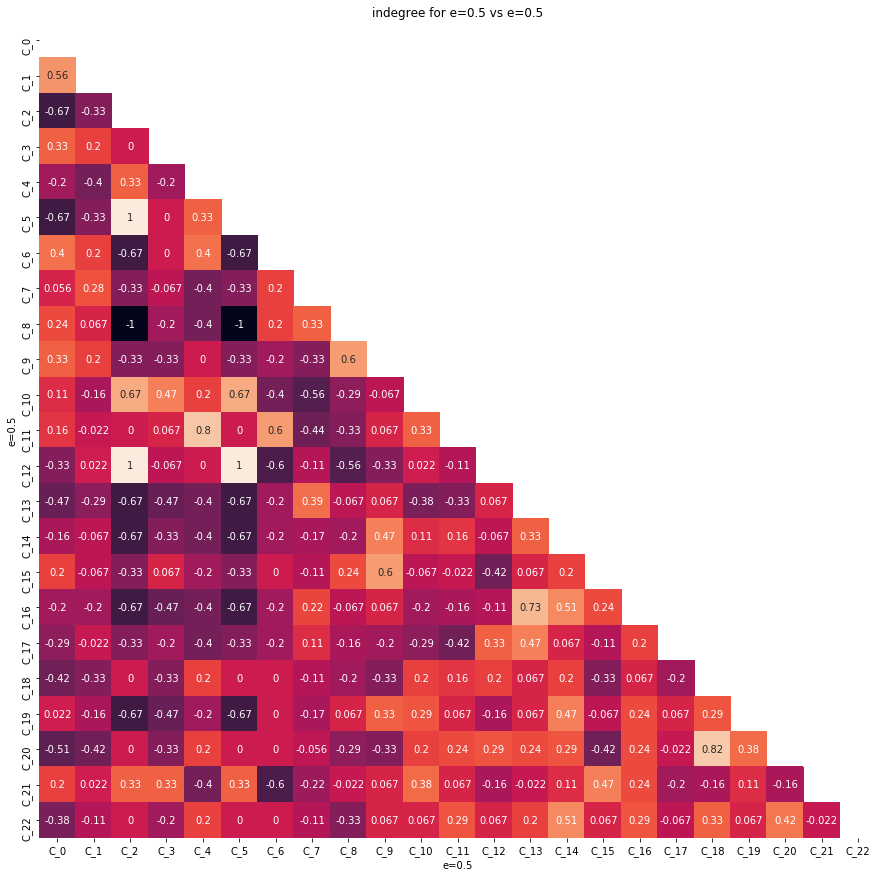

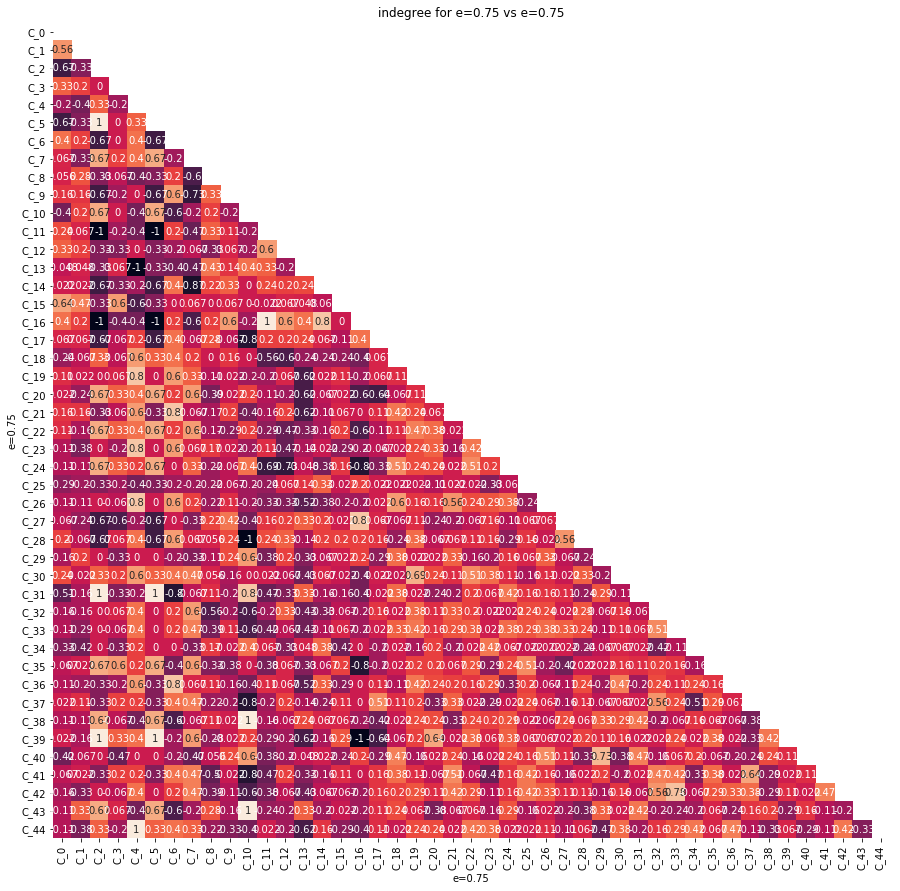

heatmaps for dataset kdd


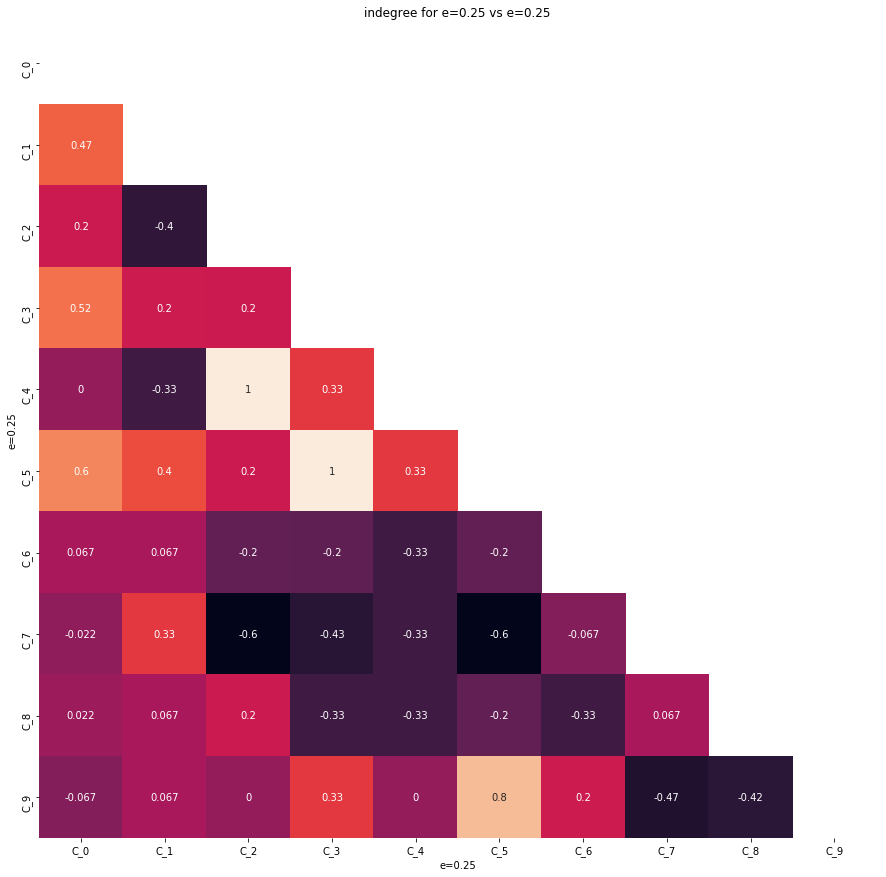

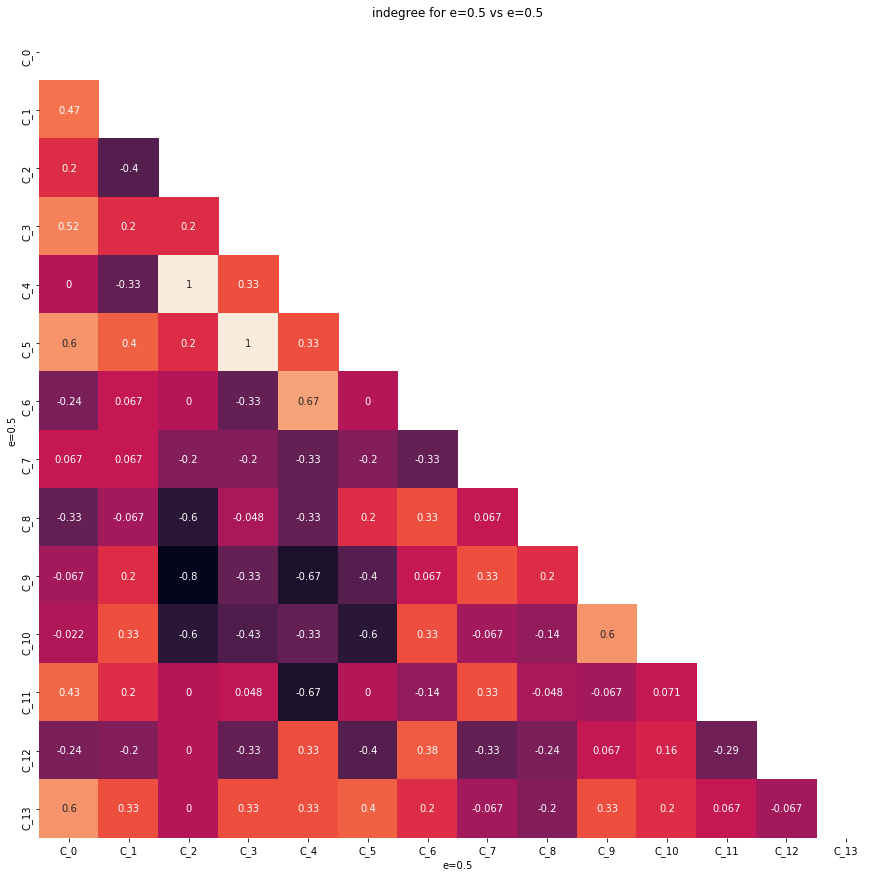

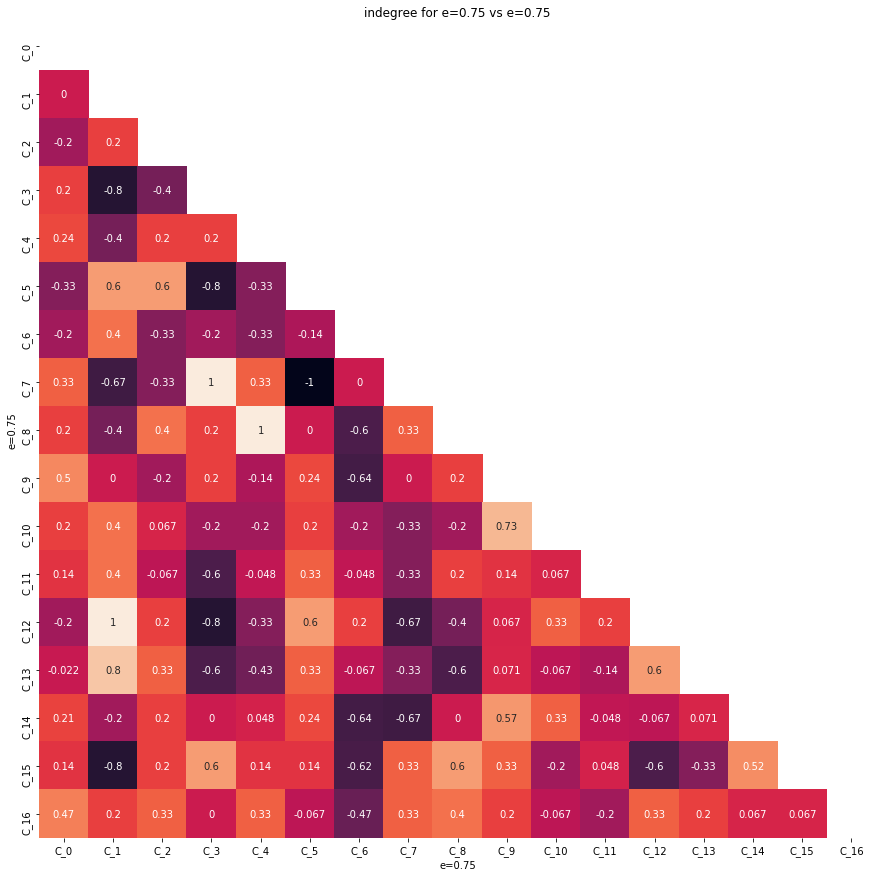

In [9]:
for data_fn in data_filenames:
    print(f'heatmaps for dataset {data_fn}')
    Analysis.communities_top_users_heatmap(m[data_fn], metric_name, e_pairs, triangular=True)

In [10]:
for data_fn in data_filenames:
    print(f'rankings for dataset {data_fn}')
    r_list = Analysis.communities_top_users_rank(m[data_fn], metric_name, e_pairs, threshold=0.6)
    for r in r_list:
        display(r.round(2))

rankings for dataset ll


/home/flaprimo/Development/Workspaces/ZikaProject/Python/twitter-network-analysis/venv/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


,p1_e0.25,p2_e0.25,indegree
0,C_10,C_9,1.0
1,C_5,C_6,0.6


,p1_e0.5,p2_e0.5,indegree
0,C_12,C_5,1.00
1,C_12,C_2,1.00
2,C_2,C_5,1.00
3,C_18,C_20,0.82
4,C_11,C_4,0.80
5,C_13,C_16,0.73
6,C_10,C_5,0.67
7,C_10,C_2,0.67
8,C_15,C_9,0.60
9,C_11,C_6,0.60


,p1_e0.75,p2_e0.75,indegree
0,C_39,C_5,1.00
1,C_31,C_5,1.00
2,C_2,C_39,1.00
3,C_2,C_31,1.00
4,C_2,C_5,1.00
5,C_11,C_16,1.00
6,C_10,C_43,1.00
7,C_10,C_38,1.00
8,C_4,C_44,1.00
9,C_36,C_6,0.80


rankings for dataset kdd


,p1_e0.25,p2_e0.25,indegree
0,C_2,C_4,1.0
1,C_3,C_5,1.0
2,C_5,C_9,0.8
3,C_0,C_5,0.6


,p1_e0.5,p2_e0.5,indegree
0,C_2,C_4,1.00
1,C_3,C_5,1.00
2,C_4,C_6,0.67
3,C_10,C_9,0.60
4,C_0,C_13,0.60
5,C_0,C_5,0.60


,p1_e0.75,p2_e0.75,indegree
0,C_3,C_7,1.00
1,C_4,C_8,1.00
2,C_1,C_12,1.00
3,C_1,C_13,0.80
4,C_10,C_9,0.73
5,C_15,C_8,0.60
6,C_15,C_3,0.60
7,C_12,C_13,0.60
8,C_12,C_5,0.60
9,C_2,C_5,0.60


#### Similarities between DIFFERENT epsilon settings
Epsilon parameter defines the likeliness of creating new communities.

Thus the most important partitions will likely "survive" with different epsilon settings.

Since we are comparing different partitions the heatmap is not triangular as before.

heatmaps for dataset ll


/home/flaprimo/Development/Workspaces/ZikaProject/Python/twitter-network-analysis/venv/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


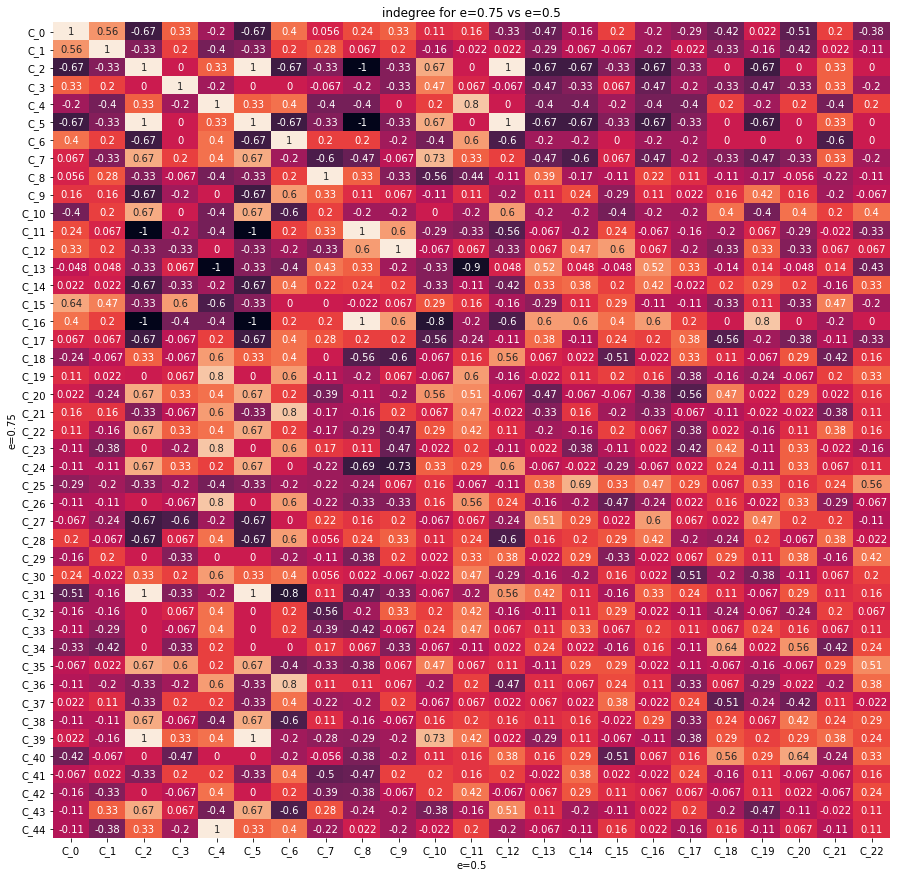

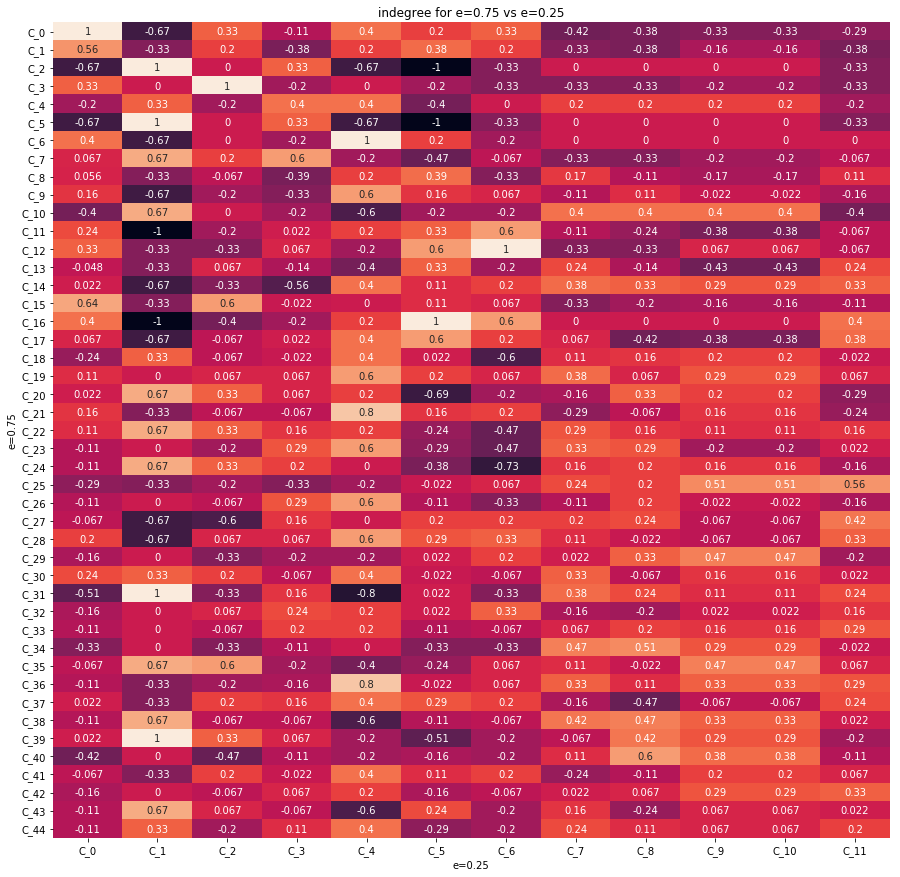

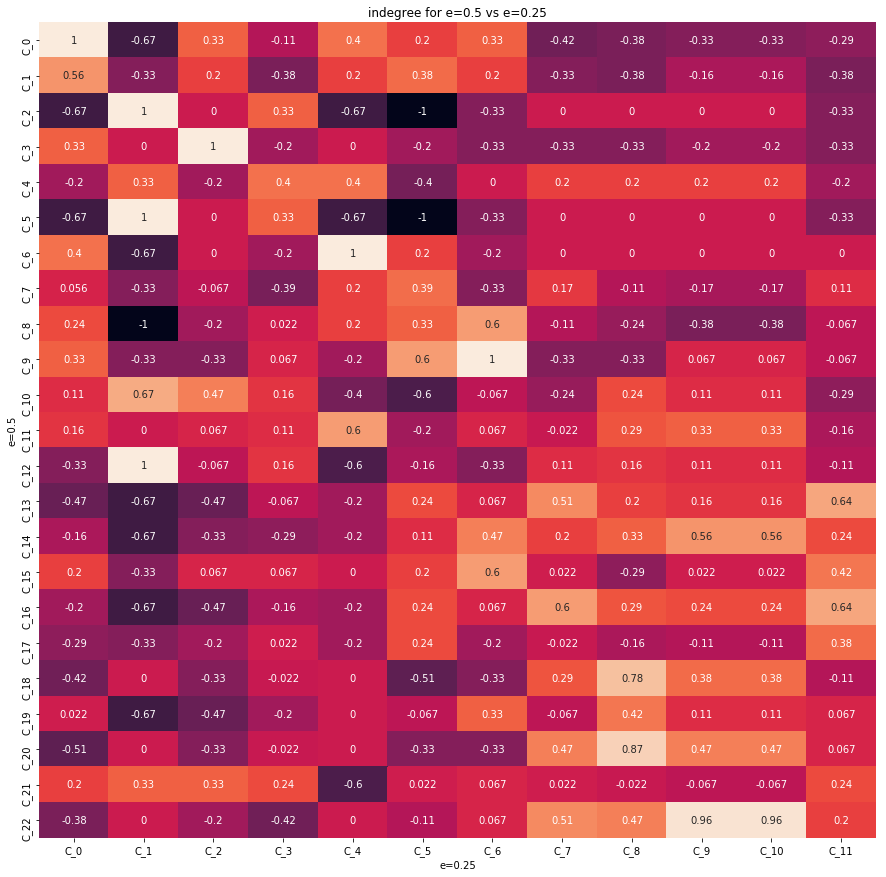

heatmaps for dataset kdd


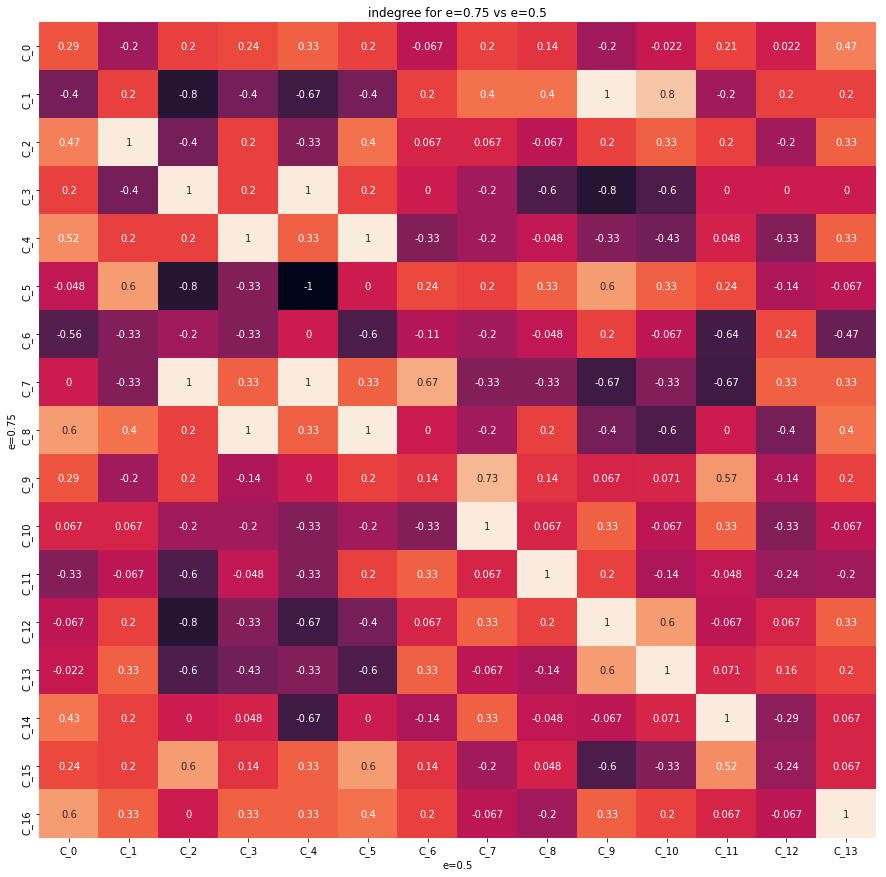

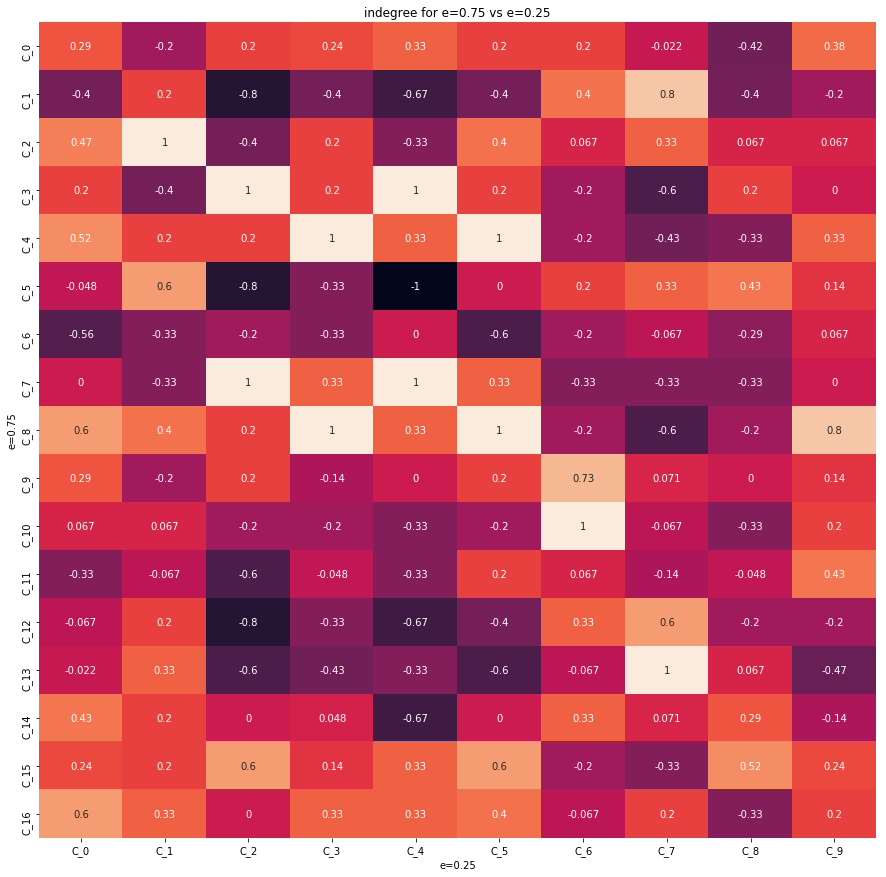

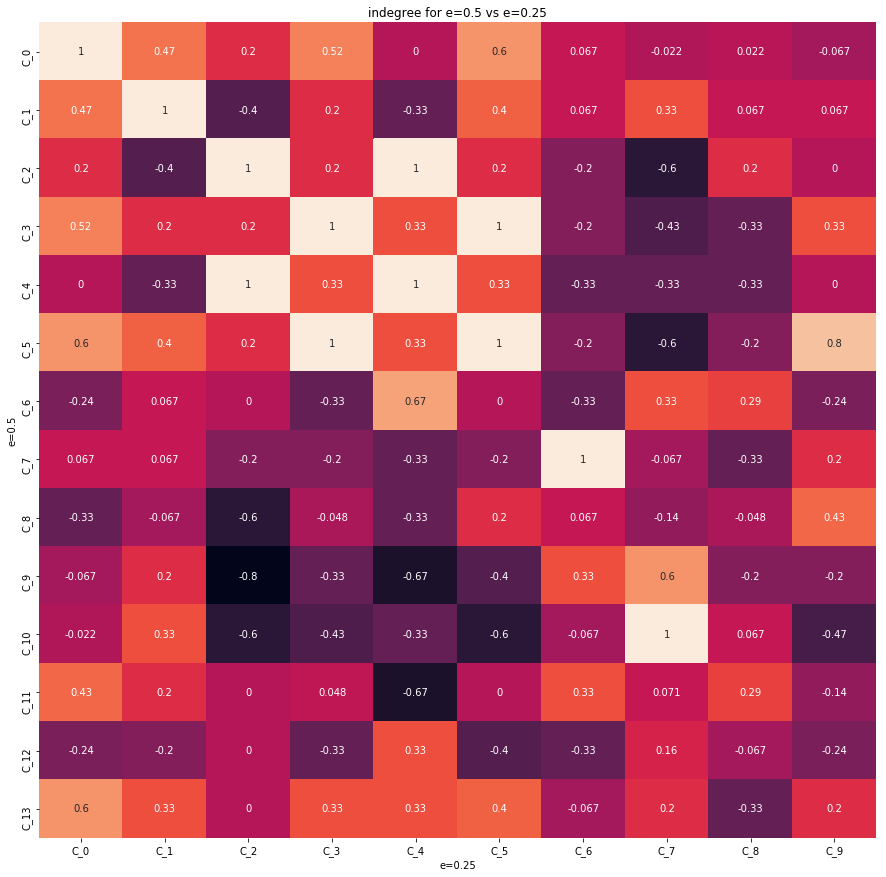

In [11]:
for data_fn in data_filenames:
    print(f'heatmaps for dataset {data_fn}')
    Analysis.communities_top_users_heatmap(m[data_fn], metric_name, e_pairwise_combs)

In [12]:
for data_fn in data_filenames:
    print(f'rankings for dataset {data_fn}')
    r_list = Analysis.communities_top_users_rank(m[data_fn], metric_name, e_pairwise_combs, threshold=0.6)
    for r in r_list:
        display(r.round(2))

rankings for dataset ll


/home/flaprimo/Development/Workspaces/ZikaProject/Python/twitter-network-analysis/venv/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


,p1_e0.75,p2_e0.5,indegree
0,C_12,C_5,1.00
1,C_12,C_2,1.00
2,C_7,C_8,1.00
3,C_2,C_5,1.00
4,C_11,C_4,0.80
5,C_10,C_7,0.73
6,C_10,C_5,0.67
7,C_10,C_2,0.67
8,C_5,C_7,0.67
9,C_2,C_20,0.67


,p1_e0.75,p2_e0.25,indegree
0,C_2,C_3,1.0


,p1_e0.5,p2_e0.25,indegree
0,C_6,C_9,1.0
1,C_6,C_8,0.6
2,C_5,C_9,0.6


rankings for dataset kdd


,p1_e0.75,p2_e0.5,indegree
0,C_4,C_7,1.00
1,C_3,C_4,1.00
2,C_2,C_7,1.00
3,C_10,C_13,1.00
4,C_5,C_8,1.00
5,C_3,C_8,1.00
6,C_2,C_3,1.00
7,C_1,C_2,1.00
8,C_7,C_9,0.73
9,C_1,C_5,0.60


,p1_e0.75,p2_e0.25,indegree
0,C_4,C_7,1.0
1,C_3,C_4,1.0
2,C_2,C_7,1.0
3,C_2,C_3,1.0
4,C_1,C_2,1.0
5,C_1,C_5,0.6


,p1_e0.5,p2_e0.25,indegree
0,C_2,C_4,1.00
1,C_6,C_7,1.00
2,C_3,C_5,1.00
3,C_4,C_6,0.67
4,C_7,C_9,0.60
5,C_0,C_5,0.60


## Comparisons
Compare DEMON community results with other community detection algorithms.

Find similarities between partitions found by different community detection algorithms with a heatmap and then list the most correlated communities.

heatmaps for dataset ll


/home/flaprimo/Development/Workspaces/ZikaProject/Python/twitter-network-analysis/venv/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


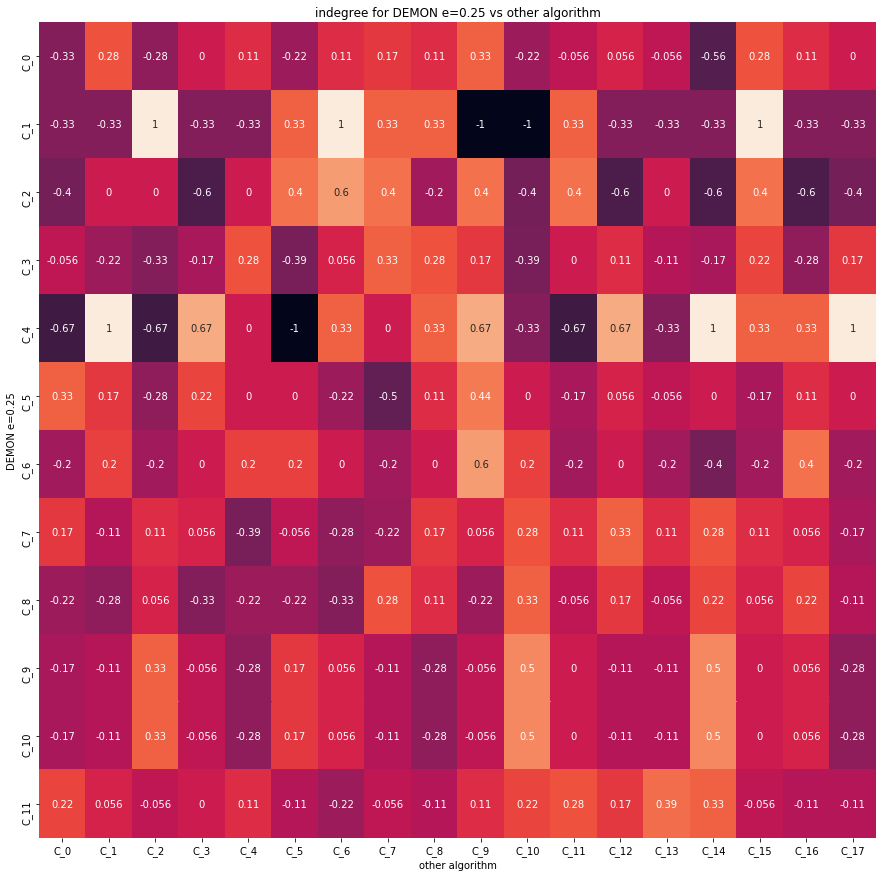

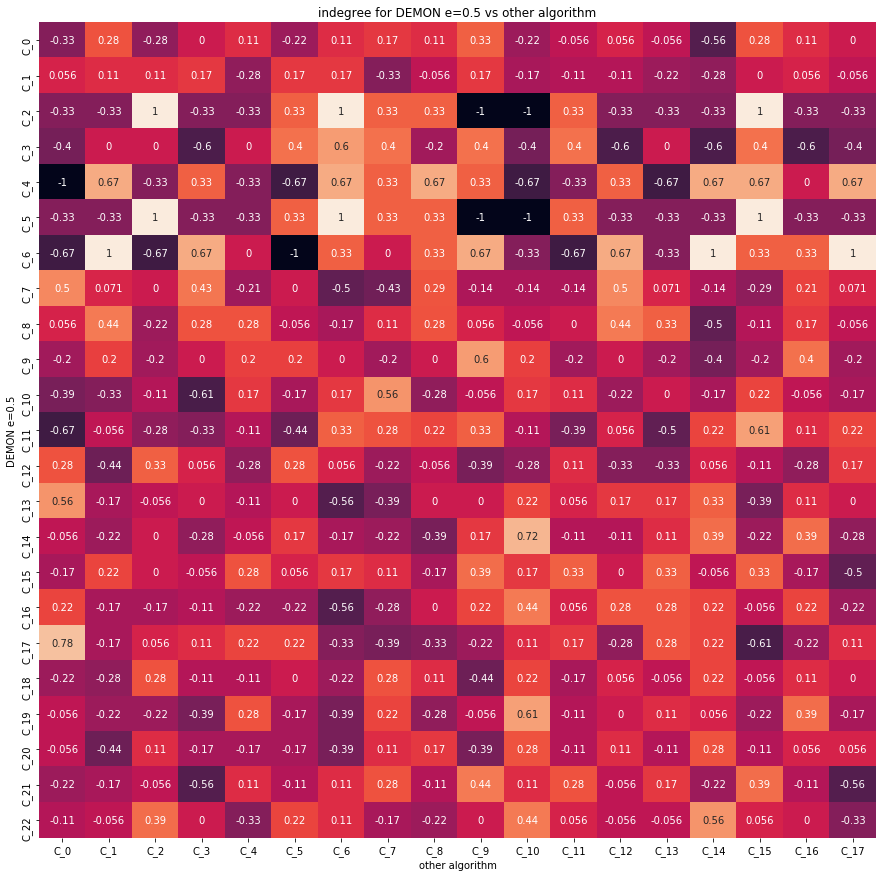

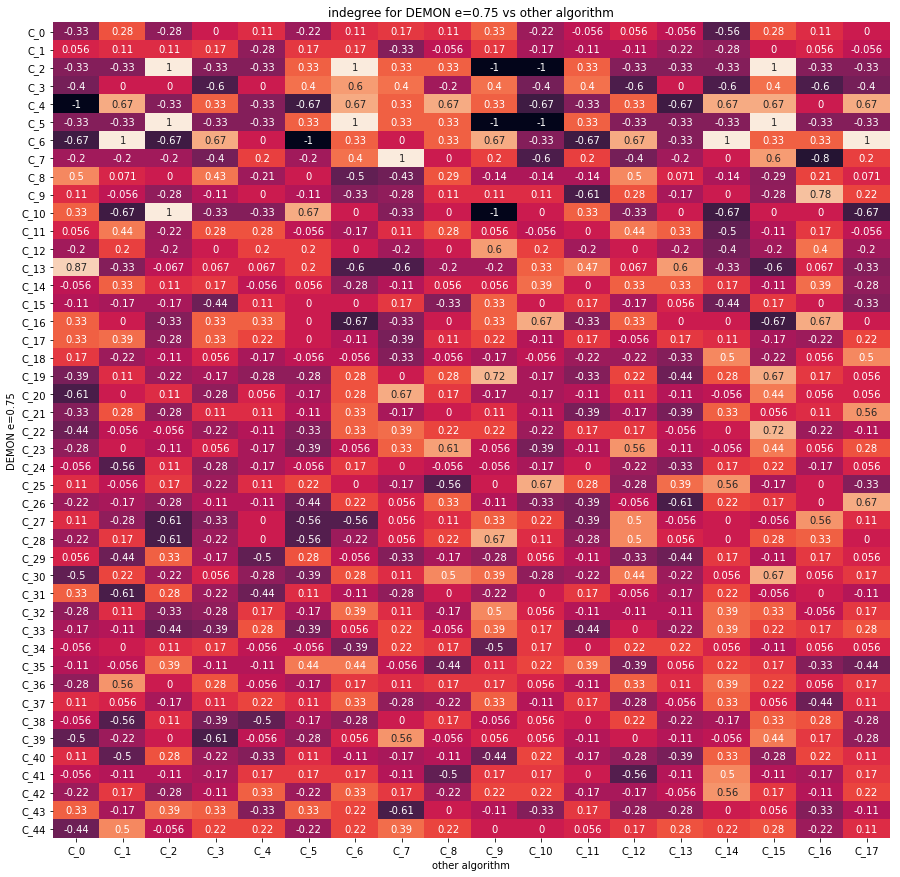

heatmaps for dataset kdd


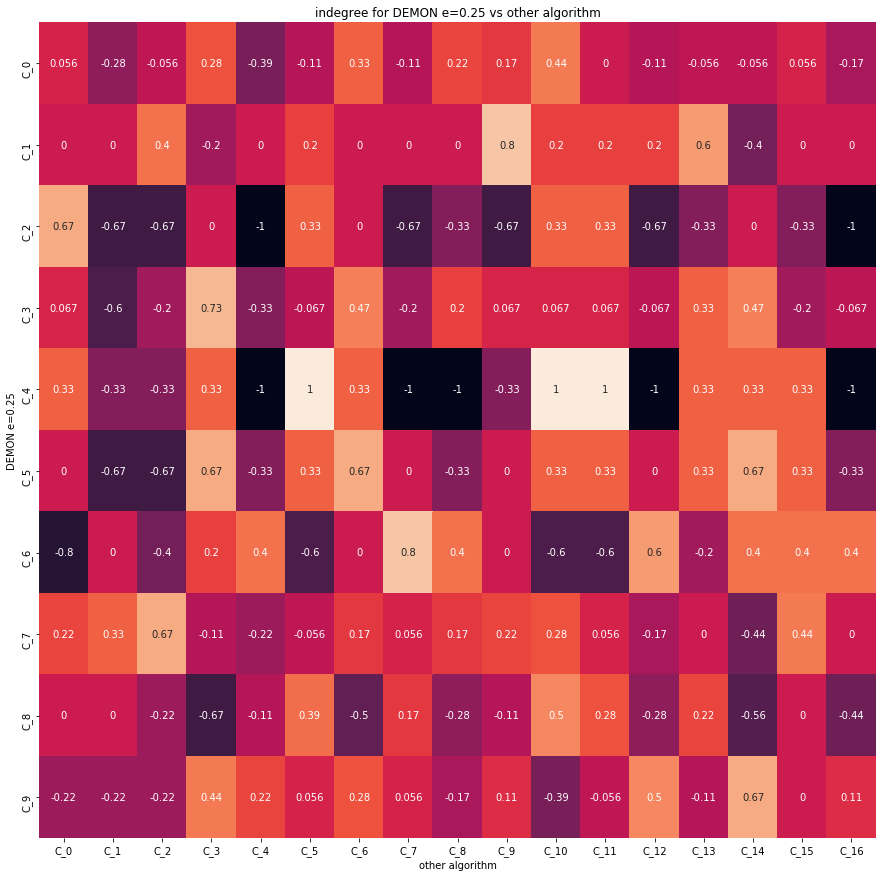

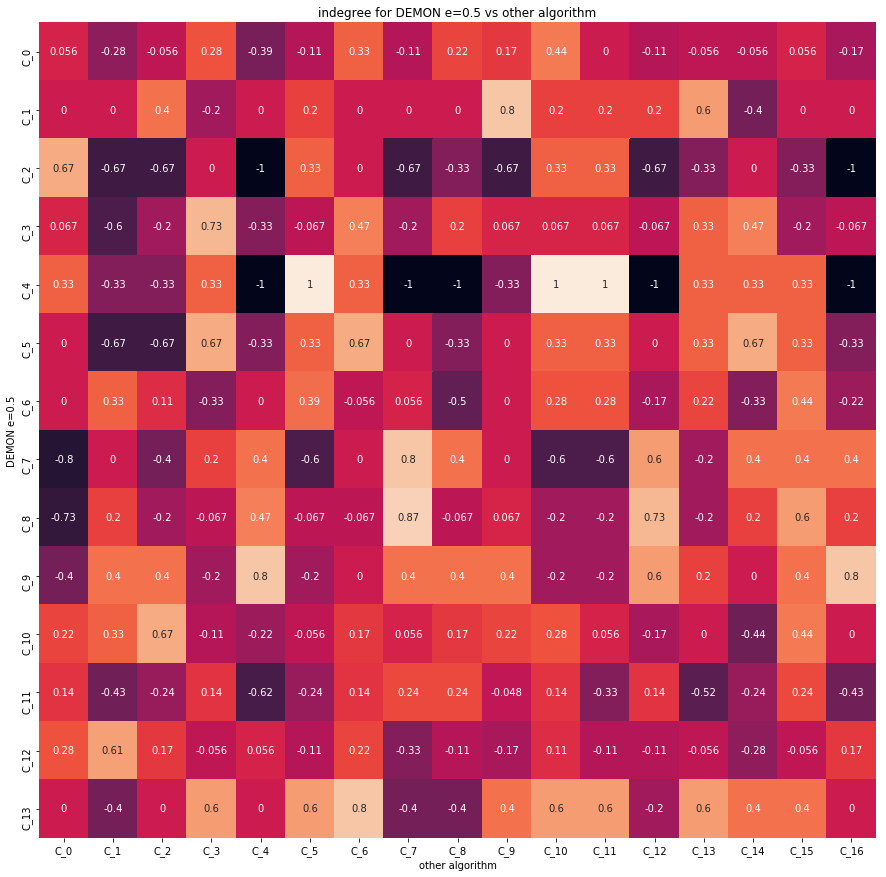

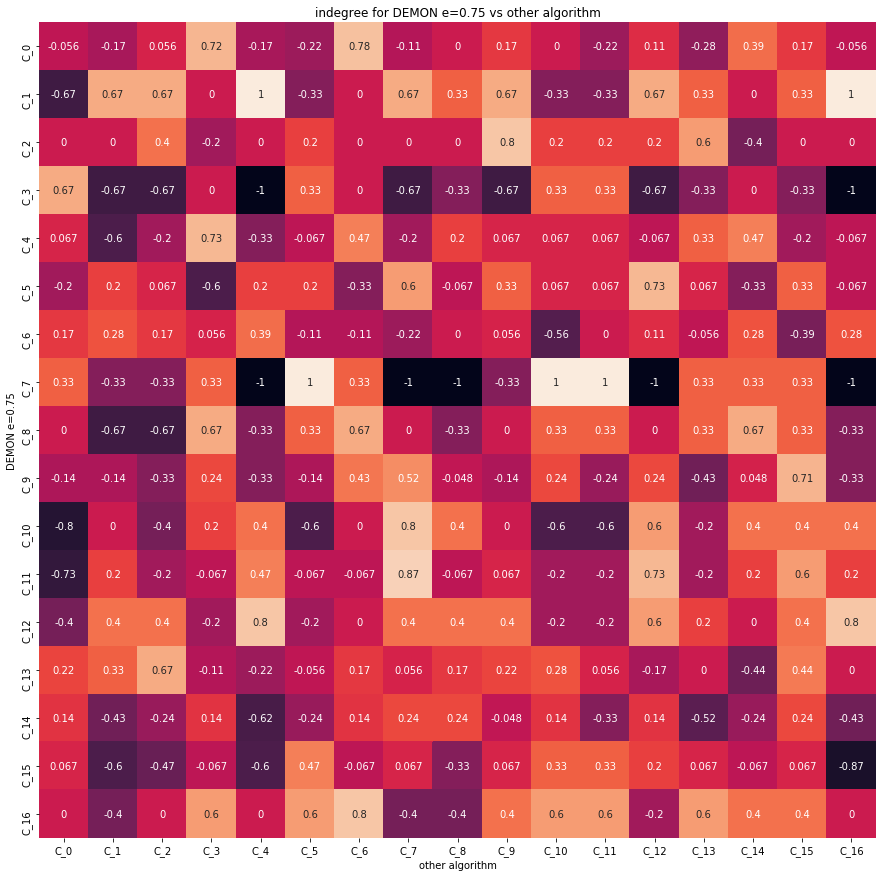

In [13]:
for data_fn in data_filenames:
    print(f'heatmaps for dataset {data_fn}')
    c = Comparisons.get_comparison_top_community(m[data_fn][epsilon[0]])
    Comparisons.communities_top_users_heatmap(m[data_fn], c, metric_name)

In [14]:
for data_fn in data_filenames:
    print(f'rankings for dataset {data_fn}')
    c = Comparisons.get_comparison_top_community(m[data_fn][epsilon[0]])
    r_list = Comparisons.communities_top_users_rank(m[data_fn], c, metric_name, 0.6)
    for r in r_list:
        display(r.round(2))

rankings for dataset ll


/home/flaprimo/Development/Workspaces/ZikaProject/Python/twitter-network-analysis/venv/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


,DEMON e=0.25,other algorithm,indegree


,DEMON e=0.5,other algorithm,indegree
0,C_17,C_6,1.00
1,C_14,C_6,1.00
2,C_3,C_6,0.67


,DEMON e=0.75,other algorithm,indegree
0,C_2,C_5,1.00
1,C_16,C_9,0.78
2,C_12,C_6,0.67
3,C_10,C_16,0.67
4,C_3,C_6,0.67


rankings for dataset kdd


,DEMON e=0.25,other algorithm,indegree
0,C_3,C_5,0.67
1,C_2,C_7,0.67


,DEMON e=0.5,other algorithm,indegree
0,C_10,C_4,1.00
1,C_4,C_9,0.80
2,C_3,C_5,0.67
3,C_1,C_12,0.61
4,C_12,C_9,0.60
5,C_12,C_7,0.60
6,C_10,C_13,0.60


,DEMON e=0.75,other algorithm,indegree
0,C_11,C_7,1.00
1,C_10,C_7,1.00
2,C_5,C_7,1.00
3,C_12,C_5,0.73
4,C_3,C_4,0.73
5,C_0,C_3,0.67
6,C_13,C_16,0.60
7,C_13,C_2,0.60
8,C_11,C_16,0.60
9,C_10,C_16,0.60
